# Spotify Popularity Trends & Correlation Analysis

In [71]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

CSV_PATH = "spotify_dataset_2010_2019.csv"


## Functions

### Load and clean

In [72]:
def load_dataset(file_path = CSV_PATH) -> pd.DataFrame:
    encodings = ["utf-8", "latin1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(file_path, encoding=enc)
        except Exception as e:
            last_err = e
    else:
        if last_err:
            raise last_err
        
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns={
        "top genre": "genre",
        "bpm": "tempo",
        "nrgy": "energy",
        "dnce": "danceability",
        "dB": "loudness",
        "live": "liveness",
        "val": "valence",
        "dur": "duration",
        "acous": "acousticness",
        "spch": "speechiness",
        "pop": "popularity"
    })
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    df["genre"] = df["genre"].astype("category")
    df["artist"] = df["artist"].astype("category")
    df["year"] = df["year"].astype(int)

    return df

### IQR filtering

In [73]:
def iqr_filter(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series >= lower) & (series <= upper)

def apply_IQR_to_single_column(df: pd.DataFrame, col_name: str):
    mask = iqr_filter(df[col_name])
    df_iqr = df[mask].copy()
    print("Original rows:", len(df), " | After IQR:", len(df_iqr))
    return df_iqr

def apply_IQR(df: pd.DataFrame):
    features_for_iqr = ["tempo", "energy", "danceability", "loudness", "liveness", "valence", "duration",
                        "acousticness", "speechiness", "popularity"]
    features_for_iqr = [c for c in features_for_iqr if c in df.columns]

    mask = pd.Series(True, index=df.index)
    for col in features_for_iqr:
        mask &= iqr_filter(df[col])

    df_iqr = df[mask].copy()
    print("Original rows:", len(df), " | After IQR:", len(df_iqr))

    return df_iqr

### Constants

In [74]:

custom_colors = [
    "#e41a1c",  # red
    "#377eb8",  # blue
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#a65628",  # brown
    "#f781bf",  # pink
    "#999999",  # gray
    "#dede00",  # yellow
    "#17becf",  # cyan
]

## Load and clean data

In [75]:
raw_df = load_dataset()
df = clean_data(raw_df)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(10)

Shape: (603, 14)
Columns: ['title', 'artist', 'genre', 'year', 'tempo', 'energy', 'danceability', 'loudness', 'liveness', 'valence', 'duration', 'acousticness', 'speechiness', 'popularity']


,title,artist,genre,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,popularity
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78
5,Baby,Justin Bieber,canadian pop,2010,65,86,73,-5,11,54,214,4,14,77
6,Dynamite,Taio Cruz,dance pop,2010,120,78,75,-4,4,82,203,0,9,77
7,Secrets,OneRepublic,dance pop,2010,148,76,52,-6,12,38,225,7,4,77
8,Empire State of Mind (Part II) Broken Down,Alicia Keys,hip pop,2010,93,37,48,-8,12,14,216,74,3,76
9,Only Girl (In The World),Rihanna,barbadian pop,2010,126,72,79,-4,7,61,235,13,4,73


## Genre Popularity Trend Over Time

genre
dance pop                    21047
pop                           4490
canadian pop                  2456
boy band                      1045
electropop                    1007
barbadian pop                  981
canadian contemporary r&b      699
british soul                   684
big room                       656
neo mellow                     540
Name: popularity, dtype: int64


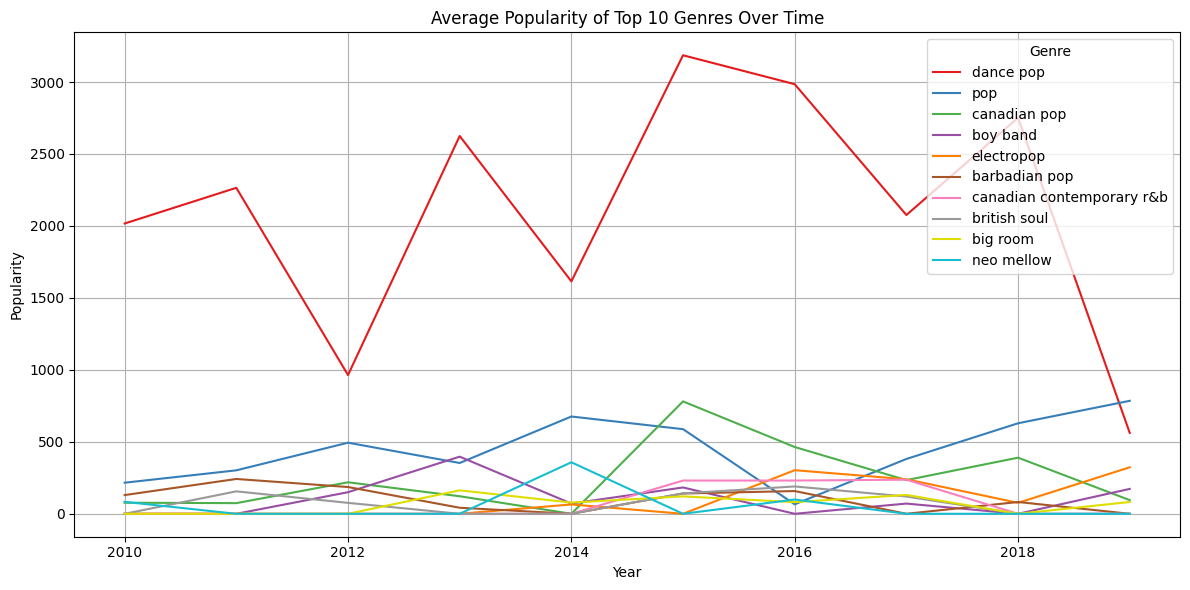

In [76]:
genre_year_pop = df.groupby(["year", "genre"], observed=False)["popularity"].sum().reset_index()
top_genres = genre_year_pop.groupby("genre", observed=False)["popularity"].sum().nlargest(10)
print(top_genres)
top_genres_names = top_genres.index.tolist()
genre_year_top = genre_year_pop[genre_year_pop["genre"].isin(top_genres_names)]

plt.figure(figsize=(12, 6))

for i, genre in enumerate(top_genres_names):
    genre_data = genre_year_top[genre_year_top["genre"] == genre]
    plt.plot(genre_data["year"], genre_data["popularity"], label=genre, color=custom_colors[i])

plt.title("Average Popularity of Top 10 Genres Over Time")
plt.xlabel("Year")
plt.ylabel("Popularity")
plt.grid(True)
plt.legend(title="Genre")
plt.tight_layout()
plt.show()


## Artist Popularity Trend Over Time

artist
Justin Bieber       1150
Maroon 5            1123
Katy Perry          1056
Rihanna              981
Lady Gaga            964
Bruno Mars           936
Ed Sheeran           862
Shawn Mendes         851
The Chainsmokers     839
Calvin Harris        782
Name: popularity, dtype: int64


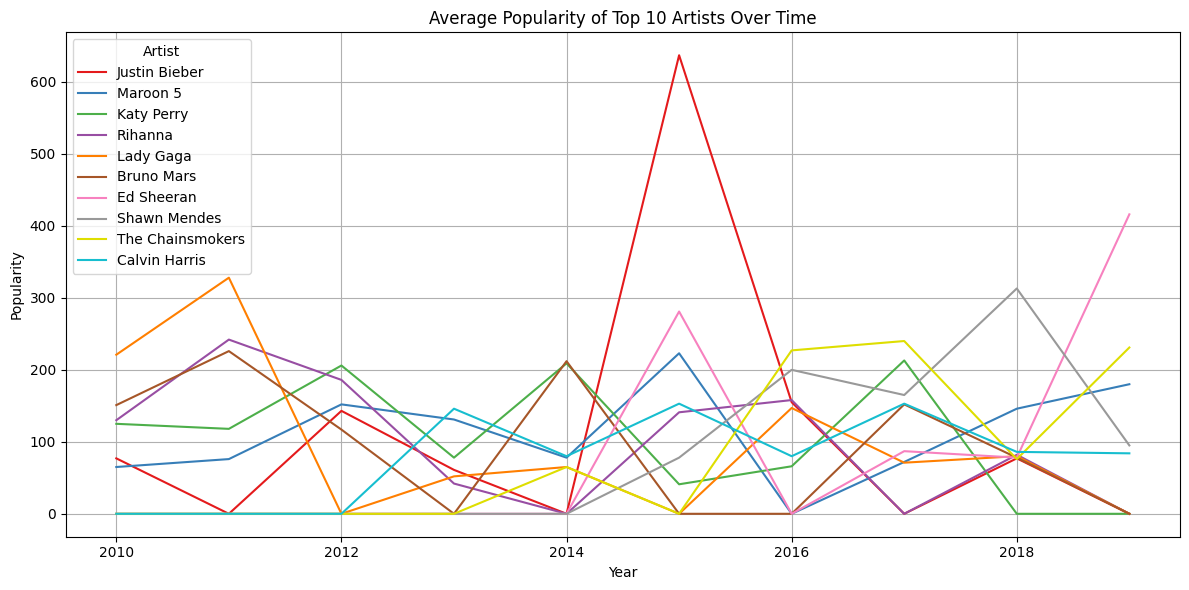

In [77]:
artist_year_pop = df.groupby(["year", "artist"], observed=False)["popularity"].sum().reset_index()
top_artists = artist_year_pop.groupby("artist", observed=False)["popularity"].sum().nlargest(10)
print(top_artists)
top_artists_names = top_artists.index.tolist()
artist_year_top = artist_year_pop[artist_year_pop["artist"].isin(top_artists_names)]

plt.figure(figsize=(12, 6))

for i, artist in enumerate(top_artists_names):
    artist_data = artist_year_top[artist_year_top["artist"] == artist]
    plt.plot(artist_data["year"], artist_data["popularity"], label=artist, color=custom_colors[i])

plt.title("Average Popularity of Top 10 Artists Over Time")
plt.xlabel("Year")
plt.ylabel("Popularity")
plt.grid(True)
plt.legend(title="Artist")
plt.tight_layout()
plt.show()


## Analytics functions

### Utils

In [78]:
def interpret_correlation(r):
    if abs(r) >= 0.7:
        return "highly correlated"
    elif abs(r) >= 0.4:
        return "medium correlated"
    elif abs(r) >= 0.2:
        return "weakly correlated"
    else:
        return "not correlated"
    

def popularity_label(x: float) -> str:
    if x >= 70:
        return "Popular"
    else:
        return "Less popular"
    
    
def interpret_p_value(p: float, mean_popular: float, mean_not_popular: float) -> str:
    if p < 0.05:
        conclusion = f"Feature is {"more" if mean_popular>mean_not_popular else "less"} inherent to popular"
        return f"Significant: {conclusion}"
    else:
        return "Not statistically strong"

### Corellation and covariance

In [79]:

def pearson_corr(df: pd.DataFrame, feature: str):
    if feature not in df.columns or "popularity" not in df.columns:
        print(f"Missing feature '{feature}' or 'popularity'.")
        return
    x = df[feature]
    y = df["popularity"]
    r = x.corr(y)
    interpretation = interpret_correlation(r)
    print(f"Pearson correlation between {feature} and popularity: r = {r:.3f} → {interpretation}.")
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=x, y=y, alpha=0.6)
    plt.title(f"Pearson Correlation: {feature} vs Popularity")
    plt.xlabel(feature)
    plt.ylabel("Popularity")
    plt.grid(True)
    plt.show()

def covariance_check(df:pd.DataFrame, feature):
    if feature not in df.columns or "popularity" not in df.columns:
        print(f"Missing feature '{feature}' or 'popularity'.")
        return
    cov = np.cov(df[feature], df["popularity"])[0, 1]
    print(f"Covariance between {feature} and popularity: {cov:.2f}")

### t-test - Compare popular tracks vs less popular tracks in terms of their characteristics

In [80]:
"""Hypotheses
    - H_0: m1 = m2 (mean feature is the same for popular and less popular tracks)
    - H_1: m1 != m2 (means differ)
    We run independent samples t‑tests on several features.

    If p < 0.05, the difference in means is statistically significant — we reject the null hypothesis
    If p ≥ 0.05, we fail to reject — there's no strong evidence of a difference.
    """

df["pop_group"] = df["popularity"].apply(popularity_label)
df["pop_bucket3"] = pd.cut(df["popularity"], bins=[-np.inf, 50, 70, np.inf], labels=["Low", "Medium", "High"])
df["pop_bucket3"] = df["pop_bucket3"].astype("category")

df["genre"] = df["genre"].astype("category")

features_to_compare = ["tempo","energy","danceability","loudness","liveness","valence","duration","acousticness","speechiness"]
features_to_compare = [f for f in features_to_compare if f in df.columns]

results = []
for feat in features_to_compare:
    g1 = df.loc[df["pop_group"] == "Popular", feat].dropna()
    g2 = df.loc[df["pop_group"] == "Less popular", feat].dropna()
    # Welch's t-test (does not assume equal variances)
    t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
    results.append(
        {
            "feature": feat,
            "Popular_mean": g1.mean(),
            "LessPopular_mean": g2.mean(),
            "t": t_stat,
            "p": p_val,
            "Conclusion": interpret_p_value(p_val, mean_popular=g1.mean(), mean_not_popular=g2.mean())
            }
    )

ttest_df = pd.DataFrame(results).sort_values("p")
ttest_df

,feature,Popular_mean,LessPopular_mean,t,p,Conclusion
2,danceability,65.942568,62.872964,2.840950,0.004652,Significant: Feature is more inherent to popular
1,energy,68.972973,71.980456,-2.275939,0.023203,Significant: Feature is less inherent to popular
4,liveness,16.712838,18.798046,-1.959668,0.050496,Not statistically strong
6,duration,222.219595,227.042345,-1.743014,0.081852,Not statistically strong
7,acousticness,15.013514,13.664495,0.798350,0.424983,Not statistically strong
5,valence,52.918919,51.557003,0.743194,0.457655,Not statistically strong
3,loudness,-5.513514,-5.641694,0.569133,0.569570,Not statistically strong
0,tempo,118.229730,118.850163,-0.306953,0.758985,Not statistically strong
8,speechiness,8.371622,8.345277,0.043205,0.965552,Not statistically strong


## Run Correlation Checks on Key Features

Original rows: 603  | After IQR: 575
Covariance between tempo and popularity: 6.83
Pearson correlation between tempo and popularity: r = 0.019 → not correlated.


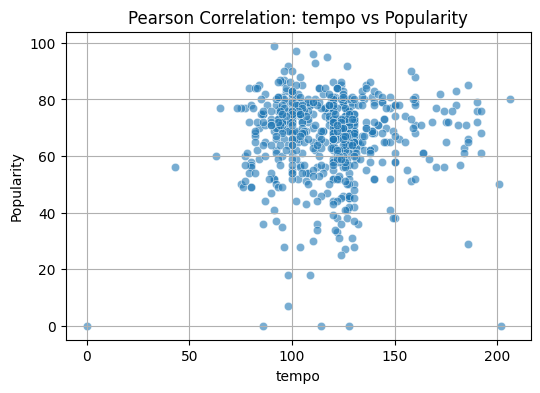

Original rows: 603  | After IQR: 592
Covariance between energy and popularity: -13.65
Pearson correlation between energy and popularity: r = -0.058 → not correlated.


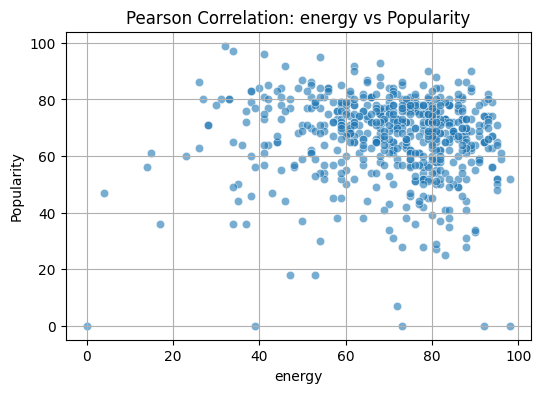

Original rows: 603  | After IQR: 586
Covariance between danceability and popularity: 22.54
Pearson correlation between danceability and popularity: r = 0.116 → not correlated.


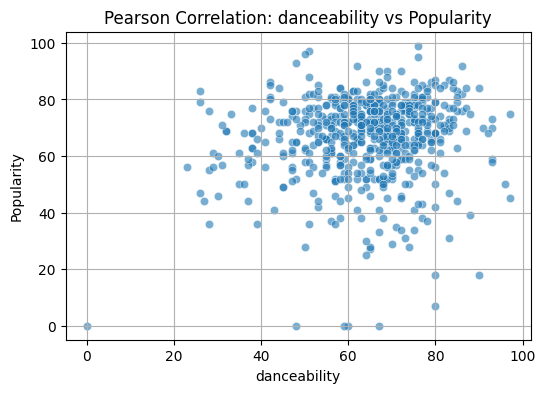

Original rows: 603  | After IQR: 588
Covariance between loudness and popularity: 6.37
Pearson correlation between loudness and popularity: r = 0.157 → not correlated.


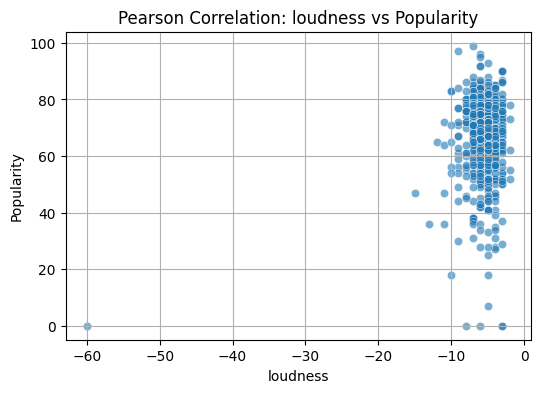

Original rows: 603  | After IQR: 580
Covariance between liveness and popularity: -14.41
Pearson correlation between liveness and popularity: r = -0.076 → not correlated.


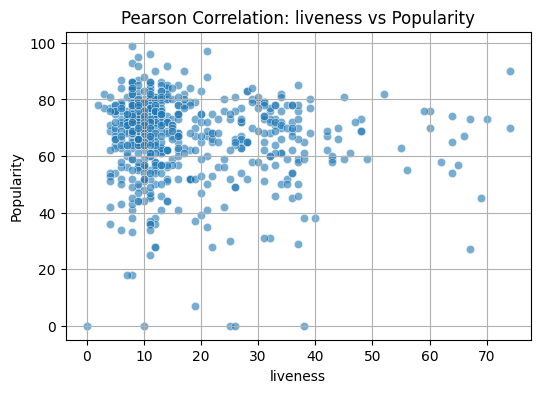

Original rows: 603  | After IQR: 603
Covariance between valence and popularity: 12.73
Pearson correlation between valence and popularity: r = 0.039 → not correlated.


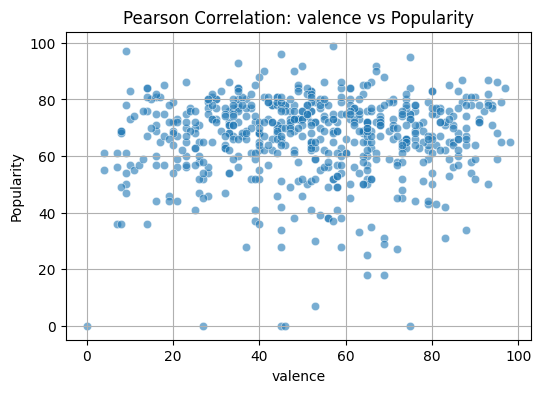

Original rows: 603  | After IQR: 584
Covariance between duration and popularity: -51.71
Pearson correlation between duration and popularity: r = -0.104 → not correlated.


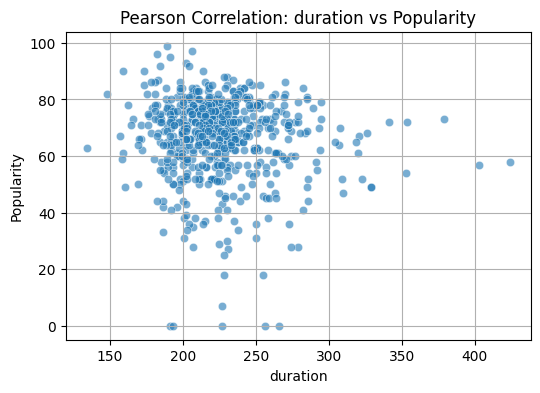

Original rows: 603  | After IQR: 537
Covariance between acousticness and popularity: 8.05
Pearson correlation between acousticness and popularity: r = 0.027 → not correlated.


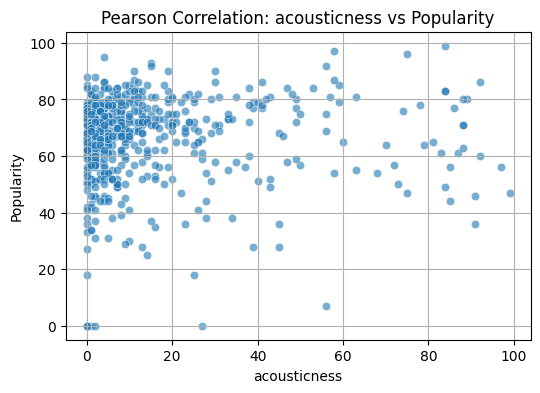

Original rows: 603  | After IQR: 537
Covariance between speechiness and popularity: -4.51
Pearson correlation between speechiness and popularity: r = -0.041 → not correlated.


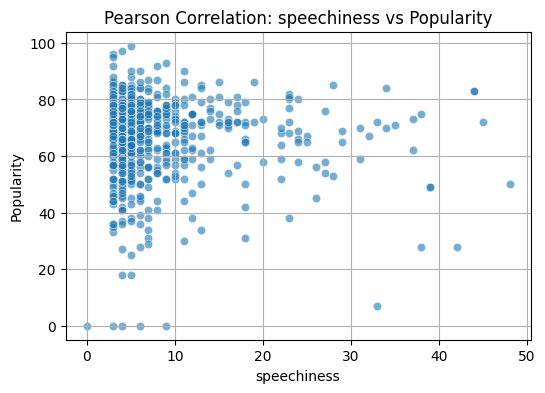

In [81]:


FEATURES = ["tempo", "energy", "danceability", "loudness", "liveness", "valence", "duration", "acousticness",
            "speechiness"]

for cur_feature in FEATURES:
    df_iqr = apply_IQR_to_single_column(df, cur_feature)
    covariance_check(df, cur_feature)
    pearson_corr(df, cur_feature)

## Conclusions

We analized most popular genres and artists for the whole period the dataset is about. 

**Most popular genres are:**

| Genre | Popularity |
|------:|:-----------|
| dance pop | 21047 |
| pop | 4490 |
| canadian pop | 2456 |
| boy band | 1045 |
| electropop | 1007 |
| barbadian pop | 981 |
| canadian contemporary r&b | 699 |
| british soul | 684 |
| big room | 656 |
| neo mellow | 540 |

**Top 10 most popular artists:**

| Artist | Popularity |
|------:|:-----------|
| Justin Bieber | 1150 |
| Maroon 5 | 1123 |
| Katy Perry | 1056 |
| Rihanna | 981 |
| Lady Gaga | 964 |
| Bruno Mars | 936 |
| Ed Sheeran | 862 |
| Shawn Mendes | 851 |
| The Chainsmokers | 839 |
| Calvin Harris | 782 |

## t-test - Compare popular tracks vs less popular tracks in terms of their characteristics

According to t-test more popular tracks tend to be less energetic and mor danceable

| Feature       | Popular_mean | LessPopular_mean | t         | p         | Conclusion                                 |
|:-------------|:-------------|:-----------------|:----------|:----------|:--------------------------------------------|
| danceability | 65.942568    | 62.872964        | 2.840950  | 0.004652  | Significant: Feature is more inherent to popular |
| energy       | 68.972973    | 71.980456        | -2.275939 | 0.023203  | Significant: Feature is less inherent to popular |
| liveness     | 16.712838    | 18.798046        | -1.959668 | 0.050496  | Not statistically strong                    |
| duration     | 222.219595   | 227.042345       | -1.743014 | 0.081852  | Not statistically strong                    |
| acousticness | 15.013514    | 13.664495        | 0.798350  | 0.424983  | Not statistically strong                    |
| valence      | 52.918919    | 51.557003        | 0.743194  | 0.457655  | Not statistically strong                    |
| loudness     | -5.513514    | -5.641694        | 0.569133  | 0.569570  | Not statistically strong                    |
| tempo        | 118.229730   | 118.850163       | -0.306953 | 0.758985  | Not statistically strong                    |
| speechiness  | 8.371622     | 8.345277         | 0.043205  | 0.965552  | Not statistically strong                    |


## Correlation - What audio features correlate with popularity?

No correlation was found between tracks popularity and musical features

